In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import drive

np.random.seed(0)

In [0]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Colab Notebooks/DELETE") 

In [0]:
# Loading image data from saved npz object. We saved all the pre-processed image data in a npz object.
# This was done as reading from image files was a time consuming operation, slowing down experimentation.

data = np.load("train_test_64_dict.npz")

y_test = data["x_test"]
y_train = data["x_train"]
row_dim = y_train.shape[1]
col_dim = y_train.shape[2]
depth_dim = y_train.shape[3]
os.chdir("/content/gdrive/My Drive/Colab Notebooks/DELETE") 

# create saved_images folder
img_path = 'saved_images_imagenet'
save_path = os.path.join(os.getcwd(), img_path)
if not os.path.isdir(save_path):
        os.makedirs(save_path)

['dog', 'truck', 'car', 'horse cart', 'ship', 'purple clematis', 'armhole', 'dolphin', 'tapestry', 'wood ant', 'nasturtium', 'tarragon', 'wort', 'plover', 'masquerader', 'toga', 'Rhodesian ridgeback', 'marshmallow', 'pull chain', 'wicket', 'conference room', 'priest', 'kit fox', 'zebu', 'post', 'koala', 'ziggurat', 'hamburger', 'New World warbler', 'pahautea', 'vitamin pill', 'giant kangaroo', 'china cabinet', 'cabin', 'gaboon viper', 'dial', 'engine', 'tailorbird', 'transvestite', 'loft', 'purple grackle', 'hill', 'patchwork', 'Black woman', 'furrow', 'soul patch', 'basilica', 'necklet', 'solar heater', 'jack', 'exhibitionist', 'blackbird', 'barred owl', 'southern buckthorn', 'sweet melon', 'spume', 'silverback', 'refracting telescope', 'johnnycake', 'water moccasin', 'liparis', 'oilcloth', 'bomber jacket', 'private', 'net', 'barberry', 'skin', 'hack', 'in-law', 'drawing chalk', 'currant', 'fur seal', 'ironmongery', 'swift', 'ormer', 'golliwog', 'pajama', 'generator', 'rosemary', 'fir

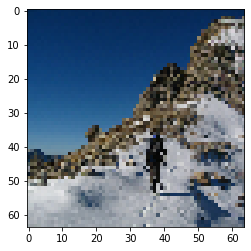

In [0]:
### IF NOT LOADING FROM DICTIONARY AS ABOVE ###

# Load the ImageNet data from files

os.chdir("/content/gdrive/My Drive/Colab Notebooks/DELETE/imagenet/imagenet_images/") 

y_train = []
y_test = []
print(os.listdir("."))
for folder in os.listdir("."):
  y_folder = []
  print(folder)
  for img in os.listdir("./" + folder):
    # Resize to (64, 64) to speed up training
    y_folder.append(cv2.resize(cv2.cvtColor(cv2.imread("./" + folder +"/"+ img), cv2.COLOR_BGR2RGB), (64, 64)))

  # Split into train and test data
  split = len(y_folder)
  f_split = (split * 9) // 10
  y_train += y_folder[:f_split]
  y_test += y_folder[f_split:]

y_test = np.array(y_test)
y_train = np.array(y_train)
print(y_train.shape, y_test.shape)

batch_select = np.arange(len(y_train))
np.random.shuffle(batch_select)
y_train = np.array(y_train)[batch_select]
plt.imshow(y_train[98])

# Get counts of data from each class. NOTE: For our problem, all images are considered as belonging to one class: "Grayscale"
for item in os.listdir("."):
  cpt = sum([len(files) for r, d, files in os.walk("./" + item)])
  print(item, cpt)


row_dim = y_train.shape[1]
col_dim = y_train.shape[2]
depth_dim = y_train.shape[3]
os.chdir("/content/gdrive/My Drive/Colab Notebooks/DELETE") 

# Output folder
img_path = 'saved_images_imagenet'
save_path = os.path.join(os.getcwd(), img_path)
if not os.path.isdir(save_path):
        os.makedirs(save_path)

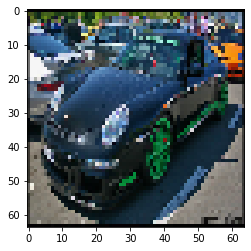

In [0]:
plt.imshow(y_train[0])

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# convert color train and test images to gray
x_train = rgb2gray(y_train)
x_test = rgb2gray(y_test)

In [0]:
# Normalize train and test images and reshape them for the model input

y_train = y_train.astype('float32') / 255
y_test = y_test.astype('float32') / 255

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.reshape(y_train.shape[0], row_dim, col_dim, depth_dim)
y_test = y_test.reshape(y_test.shape[0], row_dim, col_dim, depth_dim)

x_train = x_train.reshape(x_train.shape[0], row_dim, col_dim, 1)
x_test = x_test.reshape(x_test.shape[0], row_dim, col_dim, 1)

In [0]:
# Model_parameters

input_shape = (row_dim, col_dim, 1)
batch_size = 32
kernel_size = 3
latent_dim = 512 
filter_sizes = [64, 128, 256, 512]

In [0]:
# An autoencoder is constructed using a combination of encoder and decoder stages.
# We construct a simple 4 conv layered encoder, followed by a decoder and then attach these two models
################################################################################
# Encoder
################################################################################

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv layers as described in filter_sizes
for filters in filter_sizes:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Will be used for the first layer from the latent space to the deocder.
shape = K.int_shape(x)
x = Flatten()(x)
latent_space = Dense(latent_dim, name='latent_vector')(x)
encoder = Model(inputs, latent_space, name='encoder')
encoder.summary()


################################################################################
# Decoder
################################################################################

latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)

# Getting back the shape from the Flattened latent_space
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Reconstruct in reverse order of encoder
for filters in filter_sizes[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=depth_dim,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

################################################################################
# Constructing the Autoencoder from the Encoder and Decoder
################################################################################

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
################################################################################

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         1180160   
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 512)               4194

In [0]:
save_path = os.path.join(os.getcwd(), 'saved_models_imagenet_latent512_64_512_layer')
model_name = 'autoencoder_model_imagenet.{epoch:03d}.h5'
if not os.path.isdir(save_path):
        os.makedirs(save_path)
filepath = os.path.join(save_path, model_name)

In [0]:
# Adaptive LR, decreases on plateau of 5 epochs 
adaptive_lr = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               patience=5,
                               min_lr=0.5e-6)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

callbacks = [adaptive_lr, checkpoint]

In [0]:
history = autoencoder.fit(x_train,
                y_train,
                validation_data=(x_test, y_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

loss
accuracy
val_loss
val_accuracy
lr


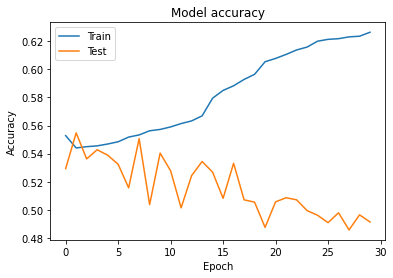

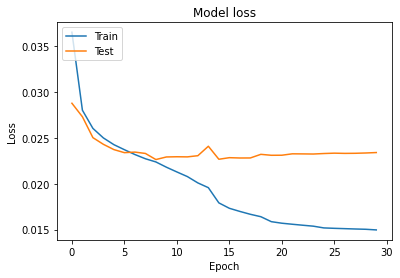

In [0]:
for k,v in history.history.items():
  print(k)

# Plot accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy for ImageNet data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("64_imagenet_acc_plot.jpeg")
plt.show()

# Plot loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for ImageNet data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("64_imagenet_loss_plot.jpeg")

In [0]:
x_decoded = autoencoder.predict(x_test)

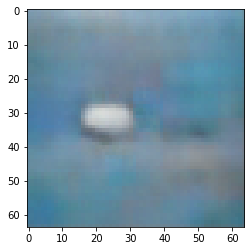

In [0]:
plt.imshow(x_decoded[49].reshape(row_dim, col_dim, depth_dim))
plt.savefig('%s/decoded_64_latent512_49_512layer.png' % img_path)

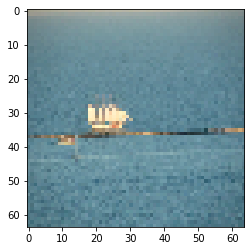

In [0]:
# autoencoder.save("working_color_imagenet_64_latent1024_512_layer.h5")
plt.imshow(y_test[49].reshape(row_dim, col_dim, depth_dim))
plt.savefig('%s/original_64_latent512_49_512layer.png' % img_path)

In [0]:
# Code to load model for testing purposes

# from tensorflow.keras.models import load_model
# autoencoder = load_model("working_color_imagenet_64_latent1024_512_layer.h5")

In [0]:
############################################################################
# Code for downloading Imagenet data
#
# ! git clone https://github.com/mf1024/ImageNet-Datasets-Downloader.git
# os.chdir("/content/gdrive/My Drive/Colab Notebooks/DELETE/ImageNet-Datasets-Downloader") 


# # ! python ./downloader.py -data_root ../imagenet \
# #       -use_class_list True \
# #       -class_list n02084071 n04490091 n02958343 n03538406 n04194289 \
# #       -images_per_class 110 
# !python ./downloader.py \
#     -data_root ../imagenet \
#     -number_of_classes 100 \
#     -images_per_class 200